## Predict full 3D image 

Todo: better support for 3D in my notebooks and Napari plugin

In [24]:
import napari
viewer =   napari.Viewer()

import czifile
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave
import torch
from pathlib import Path
from monai.inferers import sliding_window_inference
from tnia.deeplearning.dl_helper import quantile_normalization
import torch.nn.functional as F

In [25]:
parent_path = Path(r'D:\images\tnia-python-images\imagesc\2025_03_19_vessel_3D_lightsheet')
#parent_path = Path(r'/home/bnorthan/images/tnia-python-images/imagesc/2025_03_19_vessel_3D_lightsheet_2class/')
fname=Path(parent_path) / r'data/Test lightsheet.czi'
print(fname)
image = czifile.imread(fname)

D:\images\tnia-python-images\imagesc\2025_03_19_vessel_3D_lightsheet\data\Test lightsheet.czi


In [26]:
models_path = parent_path / 'models'
net = torch.load( Path(models_path) / 'model_march25.pth' )
device = torch.device("cuda")
temp = net.to(device)

In [27]:
print(image.shape)
image = np.squeeze(image)
print(image.shape)


(1, 1, 1, 1, 1, 1, 1, 1, 395, 3080, 2868, 1)
(395, 3080, 2868)


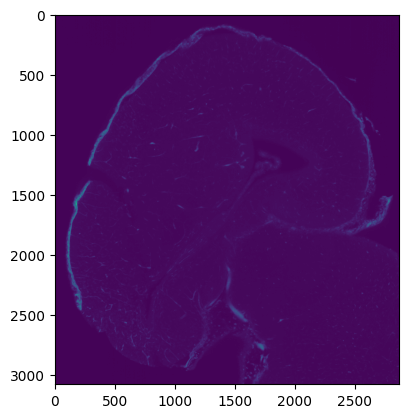

In [28]:
plt.imshow(image[200,:,:])

In [29]:
def predict(im, net):
    im = quantile_normalization(im)
    im = im.astype(np.float32)
    im_tensor = torch.from_numpy(im).unsqueeze(0).unsqueeze(0).to(device)       

    with torch.no_grad():
        #logits = net(im_tensor)  # Forward pass through the model
        # Sliding window inference
        logits = sliding_window_inference(
            im_tensor,                      # Input tensor
            1024,              # Patch size
            1,                       # Batch size during inference
            net,              # Model for inference
            #overlap=0.125          # Overlap factor

        )

    # Apply softmax along the class dimension (dim=1)
    probabilities = F.softmax(logits, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)

    predicted_classes_np = predicted_classes.squeeze(0).cpu().numpy()  # Convert to numpy array

    predicted_classes.detach_()  # Detach from the computation graph (optional, but good practice)
    logits.detach_()  # Detach logits from the computation graph (optional, but good practice)

    return predicted_classes.squeeze(0).cpu().numpy() 

In [30]:
from tqdm import tqdm
predictions = []

# Wrap the range with tqdm to display the progress bar
for i in tqdm(range(image.shape[0]), desc="Predicting"):
    image2d = image[i, :, :]
    prediction = predict(image2d, net)
    predictions.append(prediction)


# Convert the list of predictions to a 3D numpy array
predictions = np.array(predictions)
 

Predicting: 100%|██████████| 395/395 [04:31<00:00,  1.46it/s]


In [32]:
ds = 2

image_ds = image[:, ::ds, ::ds]
predictions_ds = predictions[:, ::ds, ::ds]

In [45]:
viewer.add_image(image_ds, name='image', scale = [5, 1.17*ds, 1.17*ds])
viewer.add_labels(predictions_ds, name='predictions', scale = [5, 1.17*ds, 1.17*ds])

<Labels layer 'predictions' at 0x258cafd8970>

In [35]:
ind = np.s_[200:300, 200:500, 200:500]
viewer.add_image(image_ds[ind], name='image', scale = [5, 1.17*ds, 1.17*ds])
viewer.add_labels(predictions_ds[ind], name='predictions', scale = [5, 1.17*ds, 1.17*ds])

<Labels layer 'predictions' at 0x258cbf9d630>

In [43]:
predictions_ds_thresholded = predictions_ds.copy()
predictions_ds_thresholded[image_ds < 1200] = 0#predictions_ds[image_ds < 1200]

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import erosion, ball

selem = ball(1)  # 3D structuring element with radius 3

predictions_eroded = erosion(predictions_ds, selem)

In [20]:

viewer.add_image(image, name='image', scale = [5, 1.17, 1.17])

<Image layer 'image' at 0x258cc71d0c0>

In [21]:
viewer.add_labels(predictions, name='predictions', scale = [5, 1.17, 1.17])

<Labels layer 'predictions' at 0x258c75226b0>

In [22]:
from scipy.ndimage import binary_closing, binary_opening, binary_erosion, binary_dilation

# Example: binary 3D mask
smoothed = binary_closing(predictions, iterations=1)
smoothed = binary_opening(smoothed, iterations=1)

In [23]:
viewer.add_labels(smoothed, name='smoothed', scale = [5, 1.17, 1.17])

<Labels layer 'smoothed' at 0x258bd3803d0>